Open your Anaconda Prompt and install biopython by entering:
* pip install biopython  


Additionally, install BLAST+ in your computer by executting the installer provided by the ftp link (https://ftp.ncbi.nlm.nih.gov/blast/executables/blast+/LATEST/https://ftp.ncbi.nlm.nih.gov/blast/executables/blast+/LATEST/) or provided by any of the members of our team (Windows only). Make sure you select a location that you can easily access in your directory

This code will create the csv file containing the general taxa and id factors within each gbff file:

* Make sure you correct the "path" to the location of the folders you wish to extract the content from
* Make sure you correct the "path" to the destination you want the resulting product files to be in

In [8]:
import os
import csv
from Bio import SeqIO

# Specify the path to the folder containing .gbff files (input) and the path to the output file:
gbff_folder_path = r"C:\Users\Owner\OneDrive - University of Oklahoma\Desktop\Python test Director\output_gbff_files"

output_csv_file = r"C:\Users\Owner\OneDrive - University of Oklahoma\Desktop\Python test Director\gbff_info.csv"

# Create a list to store extracted information from the gbff files by using the following handle:
def extract_and_save_gbff_info(folder_path, output_file):    
    gbff_info = []

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(".gbff"):
            gbff_path = os.path.join(folder_path, filename)
 
            for record in SeqIO.parse(gbff_path, "genbank"):                
                organism_name = record.annotations.get("organism", "N/A")
                accession_number = record.id
                description = record.description
                total_length = len(record.seq)
                
                # Append the extracted information to the list
                gbff_info.append([organism_name, filename, accession_number, description, total_length])

    # Save the information to a CSV file
    with open(output_file, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(["Organism Name", "File Name", "Accession Number", "Description", "Total Length"])
        csv_writer.writerows(gbff_info)

if __name__ == "__main__":
    extract_and_save_gbff_info(gbff_folder_path, output_csv_file)

The code below will create a csv list of the unique names of the chromosomal genebank, excluding individual entries for plasmids or phage entries that are segregated in the first csv file from the code above: 

In [9]:
import pandas as pd

input_csv_path = r"C:\Users\Owner\OneDrive - University of Oklahoma\Desktop\Python test Director\gbff_info.csv"

output_csv_path = r"C:\Users\Owner\OneDrive - University of Oklahoma\Desktop\Python test Director\combined_targets_figures.csv"

# Create a data frame and sort by the specified column
df = pd.read_csv(input_csv_path)
df.sort_values(by='File Name', inplace=True)

# Remove duplicate names
df.drop_duplicates(subset='File Name', keep='first', inplace=True)
df['File Name'] = df['File Name'].str.replace('.gbff', '')

# Select the specific column you want to copy
column_to_copy = 'File Name'
selected_column = df[column_to_copy]

# Create a new output DataFrame with the selected column
new_df = pd.DataFrame({column_to_copy: selected_column})
new_df.to_csv(output_csv_path, index=False)

print(f"CSV file sorted with no duplicates. Result saved to {output_csv_path}.")

CSV file sorted with no duplicates. Result saved to C:\Users\Owner\OneDrive - University of Oklahoma\Desktop\Python test Director\combined_targets_figures.csv.


Code that will iterate trhough all the .gbff files and extract all the nucleic acid sequences with their assigned ID number and append them in text format into one FASTA file in your destination of choosing:


In [11]:
import os
from Bio import SeqIO

gbff_folder = r"C:\Users\Owner\OneDrive - University of Oklahoma\Desktop\Python test Director\output_gbff_files"

fasta_file = r"C:\Users\Owner\OneDrive - University of Oklahoma\Desktop\Python test Director\combined_genomes.fasta"

# Create a list to store SeqRecord objects
genome_records = []

for filename in os.listdir(gbff_folder):
    if filename.endswith(".gbff"):
        gbff_file = os.path.join(gbff_folder, filename)
        for gbff_record in SeqIO.parse(gbff_file, "genbank"):
            accession_number = gbff_record.id
            file_name = os.path.splitext(os.path.basename(gbff_file))[0]
            genome_seq = gbff_record.seq
            record_id = f"{accession_number}_{file_name}"
            record = gbff_record.__class__(genome_seq, id=record_id, description="")
            genome_records.append(record)

# Direct the combined genome sequences extracted from the gbff files to a FASTA file that will be used to make a data base
with open(fasta_file, "w") as output_handle:
    SeqIO.write(genome_records, output_handle, "fasta")

print(f'Combined genome sequences with file names and accession numbers saved to {fasta_file}')

Combined genome sequences with file names and accession numbers saved to C:\Users\Owner\OneDrive - University of Oklahoma\Desktop\Python test Director\combined_genomes.fasta


Open your annaconda prompt window and type the following entry to create a data base in your computer. Make sure that before you enter this command, you are happy with the directory is going to be saved in. You may change the "in" and "out" names of your files.

Following the creation of the data base, enter the following command to generate a blast.txt file:

The first part, "blastn" is specifying nucleotide blast, you may also use "blastp" for proteins, assuming of course you made your own data base using protein entries instead. 
* The "query" is indicating the name of the file that contains the sequence of your gene of interest that is going to be blasted agaianst your "db" entry (use the name of the data base that you entered in your "makeblastdb" command before. 
* You may specify different parameters to vary the quality and specificity of your blast, such as "evalue" or "word_size", in this case we limited to just evalue (The smaller the value, the more "relevant identity" there is compared to the size of your data base. You may delete this part if you want to use the default settings of the app)
* Create the resulting blast file with "out". Make sure you specify the type of file you want your blast results to be. In this case, we made it a .txt file. 
* Finally, specify the task for the nucleotide blast, in this case, a "megablast". 

You should now have a .txt file with the relevant hits in your data base to your query.

The code below is to be used after executing your local BLAST and creating a result.txt file. This code will read the file and extract essential information for the positive hits in the file based on your BLASTING parameters into a CSV file: 

In [17]:
import pandas as pd
delimiter = ">"

# Open the BLAST .txt file
file_path = r"C:\Users\Owner\OneDrive - University of Oklahoma\Desktop\Python test Director\stx2_Megablast_Results.txt"
with open(file_path, "r") as file:
    file_content = file.read()
    
# Split the file content into sections using the delimiter
sections = file_content.split(delimiter)

gene_info_list = []

# Initialize a counter to track the genome number
gene_counter = 0
for section in sections:
    if not section:
        continue  
    info = {"Name": None, "Score": None, "Expect": None, "Identities (%)": None, "Gaps": None, "Strand": None}

    lines = section.split("\n")   

    if lines:
        name_parts = lines[0].replace(">", "").split("_", 1)
        if len(name_parts) > 1:
            info["Name"] = name_parts[1].strip()
 
    for line in lines:

        if "Score =" in line:
            score_info = line.split(" bits")
            info["Score"] = score_info[0].replace("Score =", "").strip()
            info["Expect"] = score_info[1].split("=")[1].strip()
        elif "Identities =" in line:
            # Extract the percentage portion
            percentage_part = line.split("(")[1].split("%")[0].strip()
            info["Identities (%)"] = percentage_part
            info["Gaps"] = line.split("Gaps =")[1].split("/")[0].strip()
        elif "Strand=" in line:
            info["Strand"] = line.split("Strand=")[1].strip()

    gene_info_list.append(info)

df_gene = pd.DataFrame(gene_info_list)

df_gene.to_csv(r"C:\Users\Owner\OneDrive - University of Oklahoma\Desktop\Python test Director\stx2_results.csv", index=False)

In [19]:
import pandas as pd

# Load the CSV files into Pandas DataFrames
df_gbff = pd.read_csv(r'C:\Users\Owner\OneDrive - University of Oklahoma\Desktop\Python test Director\combined_targets_figures.csv')
df_eae = pd.read_csv(r"C:\Users\Owner\OneDrive - University of Oklahoma\Desktop\Python test Director\eae_results.csv")
df_tir = pd.read_csv(r"C:\Users\Owner\OneDrive - University of Oklahoma\Desktop\Python test Director\tir_results.csv")
df_stx1 = pd.read_csv(r"C:\Users\Owner\OneDrive - University of Oklahoma\Desktop\Python test Director\stx1_results.csv")
df_stx2 = pd.read_csv(r"C:\Users\Owner\OneDrive - University of Oklahoma\Desktop\Python test Director\stx2_results.csv")

# Extract the 'File Name' column from each DataFrame
file_names_gbff = set(df_gbff['File Name'])
file_names_eae = set(df_eae['Name'])
file_names_tir = set(df_tir['Name'])
file_names_stx1 = set(df_stx1['Name'])
file_names_stx2 = set(df_stx2['Name'])

df_gbff.sort_values(by='File Name', inplace=True)

# Add a new column 'Result' to df_gbff with default value 'negative'
df_gbff['eae Result'] = 'negative'
df_gbff['tir Result'] = 'negative'
df_gbff['Stx1 Result'] = 'negative'
df_gbff['Stx2 Result'] = 'negative'

# Update 'Result' column based on common 'File Name' between gbff and eae
df_gbff.loc[df_gbff['File Name'].isin(file_names_eae), 'eae Result'] = 'positive'
df_gbff.loc[df_gbff['File Name'].isin(file_names_tir), 'tir Result'] = 'positive'
df_gbff.loc[df_gbff['File Name'].isin(file_names_stx1), 'Stx1 Result'] = 'positive'
df_gbff.loc[df_gbff['File Name'].isin(file_names_stx2), 'Stx2 Result'] = 'positive'

# Print the modified df_gbff DataFrame
print(df_gbff)
df_gbff.to_csv(r"C:\Users\Owner\OneDrive - University of Oklahoma\Desktop\Python test Director\Target_results.csv", index=False)

                               File Name eae Result tir Result Stx1 Result  \
0       GCA_000005845.2_ASM584v2_genomic   negative   negative    negative   
1       GCA_000008865.2_ASM886v2_genomic   positive   positive    positive   
2    GCA_003697165.2_ASM369716v2_genomic   negative   negative    negative   
3    GCA_003966465.1_ASM396646v1_genomic   positive   positive    positive   
4    GCA_004358405.1_ASM435840v1_genomic   positive   positive    positive   
5   GCA_014058445.2_ASM1405844v2_genomic   positive   positive    positive   
6   GCA_024300685.1_ASM2430068v1_genomic   positive   positive    positive   
7   GCA_027925505.1_ASM2792550v1_genomic   positive   positive    positive   
8   GCA_027925745.1_ASM2792574v1_genomic   positive   positive    positive   
9   GCA_027925785.1_ASM2792578v1_genomic   positive   positive    positive   
10  GCA_027925805.1_ASM2792580v1_genomic   positive   positive    positive   
11  GCA_027925825.1_ASM2792582v1_genomic   positive   positive  

Below is a simple code that will count the number of positives and negatives in the data frame of the total hits for each target and creat a figure displaying the frequency of each individual gene to the total number of genomes in the data base:

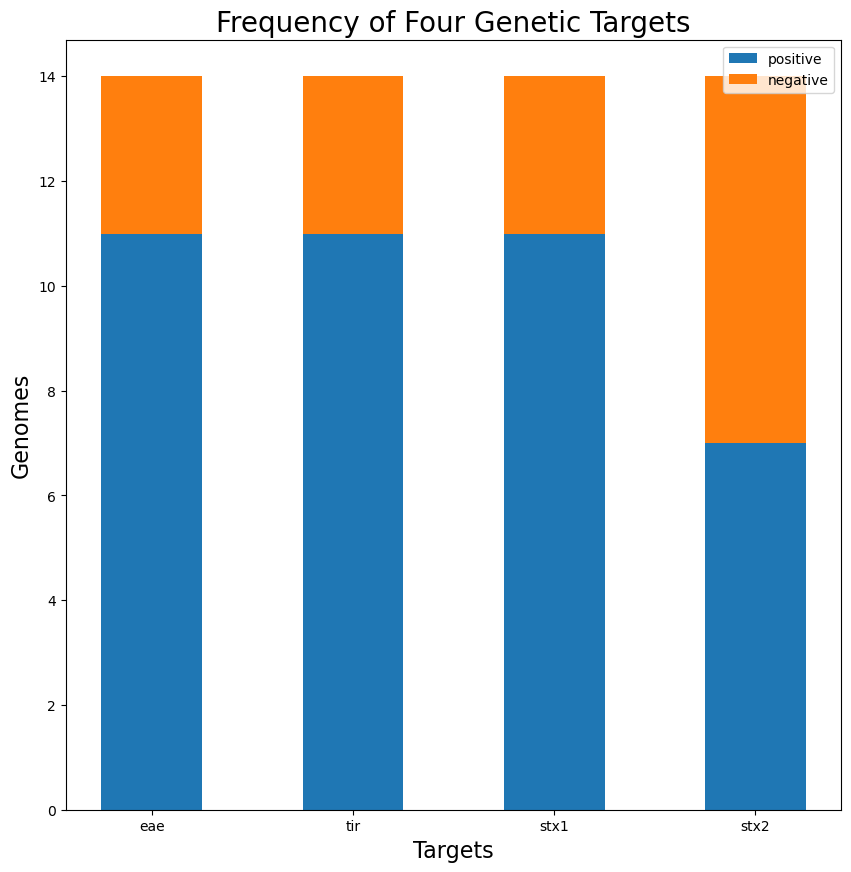

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Read the CSV file into a DataFrame
df_ALL = pd.read_csv(r'C:\Users\Owner\OneDrive - University of Oklahoma\Desktop\Python test Director\Target_results.csv')

# Extract the 'eae Result' column from the DataFrame
eae_results = df_ALL['eae Result']
tir_results = df_ALL['tir Result']
stx1_results = df_ALL['Stx1 Result']
stx2_results = df_ALL['Stx2 Result']

# Count the occurrences of 'positive' and 'negative' in each result column
eae_positives = eae_results[eae_results == 'positive'].count()
tir_positives = tir_results[tir_results == 'positive'].count()
stx1_positives = stx1_results[stx1_results == 'positive'].count()
stx2_positives = stx2_results[stx2_results == 'positive'].count()

eae_negatives = len(eae_results) - eae_positives
tir_negatives = len(tir_results) - tir_positives
stx1_negatives = len(stx1_results) - stx1_positives
stx2_negatives = len(stx2_results) - stx2_positives

targets = ['eae', 'tir', 'stx1', 'stx2']
positives = [eae_positives, tir_positives, stx1_positives, stx2_positives]
negatives = [eae_negatives, tir_negatives, stx1_negatives, stx2_negatives]
width = 0.5

# Make a simple figure
fig, ax = plt.subplots(figsize=(10, 10))

# Create stacked bar chart
bars_pos = ax.bar(targets, positives, width, label='positive')
bars_neg = ax.bar(targets, negatives, width, bottom=positives, label='negative')

# Add counts on top of the bars
for bar in bars_pos + bars_neg:
    yval = bar.get_height()
    
ax.set_title("Frequency of Four Genetic Targets", fontsize = 20)
ax.set_ylabel("Genomes", fontsize = 16)
ax.set_xlabel("Targets", fontsize = 16)
ax.legend()

plt.savefig('Combined_results_bar_chart.png', bbox_inches='tight')
plt.show()